In [ ]:
import fastai
from fastai.vision import *
from fastai.vision.gan import *
from fastai.callbacks import *

In [ ]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'crappy'

In [ ]:
import warnings
warnings.filterwarnings('ignore')

**Crapification**

In [ ]:
from PIL import Image, ImageDraw, ImageFont

class crappifier(object):
    def __init__(self, path_lr, path_hr):
        self.path_lr = path_lr
        self.path_hr = path_hr              
        
    def __call__(self, fn, i):       
        dest = self.path_lr/fn.relative_to(self.path_hr)    
        dest.parent.mkdir(parents=True, exist_ok=True)
        img = PIL.Image.open(fn)
        targ_sz = resize_to(img, 96, use_min=True)
        img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
        w,h = img.size
        q = random.randint(10,70)
        ImageDraw.Draw(img).text((random.randint(0,w//2),random.randint(0,h//2)), str(q), fill=(255,255,255))
        img.save(dest, quality=q)

In [ ]:
il = ImageList.from_folder(path_hr)

In [ ]:
parallel(crappifier(path_lr, path_hr), il.items)

In [ ]:
bs,size = 24,160
arch = models.resnet34

**Pre-trained Generator**

In [ ]:
arch = models.resnet34
src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

In [ ]:
def get_data(bs, size):
  data = (src.label_from_func(lambda x: path_hr/x.name)
  .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
  .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

  data.c=3
  return data

In [ ]:
data_gen = get_data(bs, size)

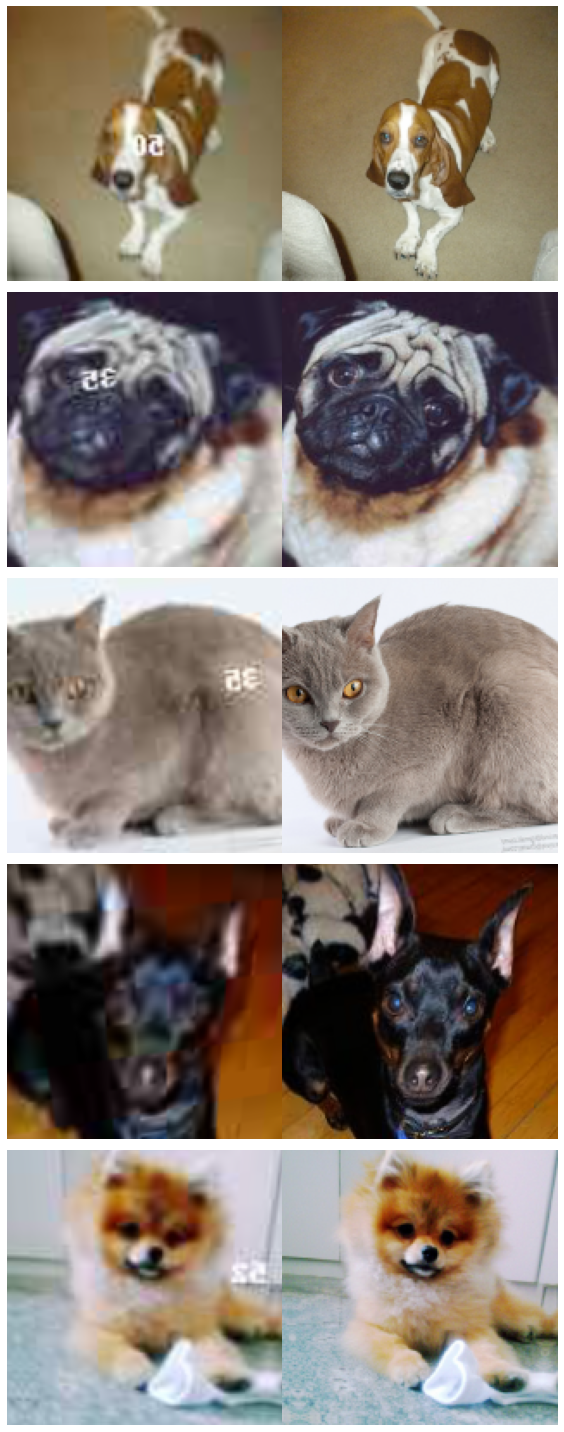

In [ ]:
data_gen.show_batch(5)

In [ ]:
wd = 1e-3

In [ ]:
y_range = (-3., 3.)

In [ ]:
loss_gen = MSELossFlat()

In [ ]:
def create_gen_learner():
  return unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight,
                         self_attention=True, y_range=y_range, loss_func=loss_gen)

In [ ]:
learn_gen = create_gen_learner()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [ ]:
learn_gen.fit_one_cycle(2, pct_start=0.8)

In [ ]:
learn_gen.unfreeze()

In [ ]:
learn_gen.fit_one_cycle(3, slice(1e-6,1e-3))

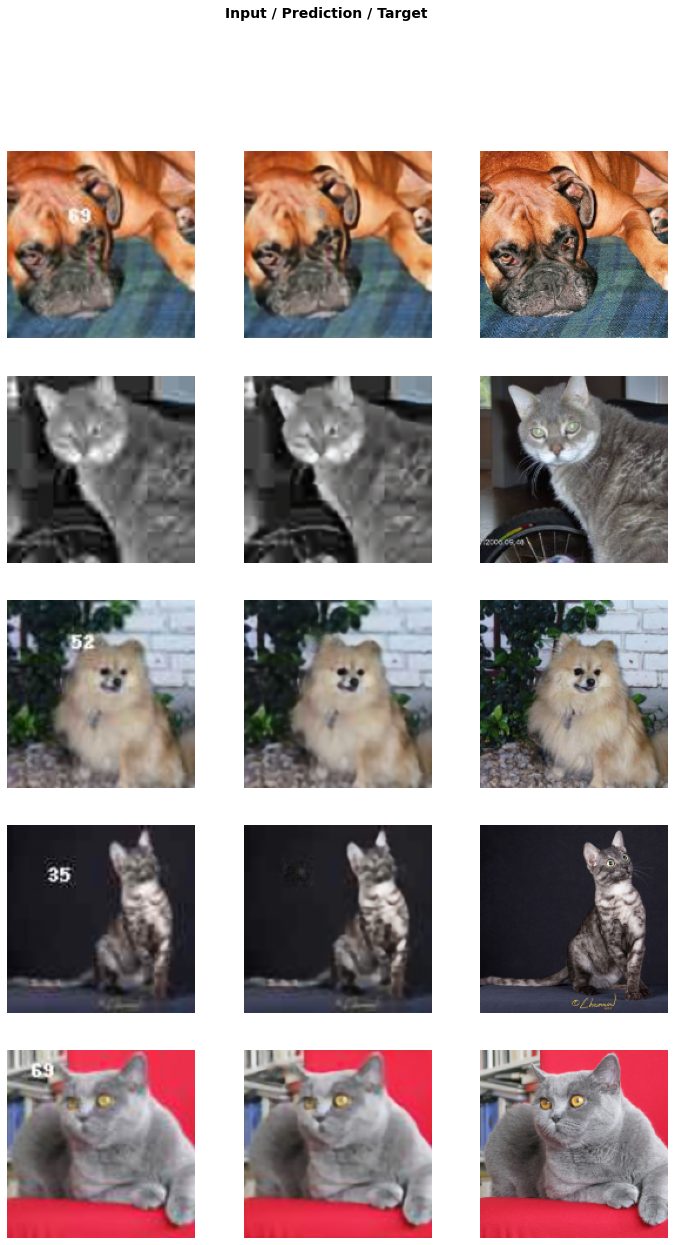

In [ ]:
learn_gen.show_results(5)

In [ ]:
learn_gen.save('gen-pre2')

**Saving Generated Images**

In [ ]:
learn_gen.load('gen-pre2')

Learner(data=ImageDataBunch;

Train: LabelList (6651 items)
x: ImageImageList
Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160)
y: ImageList
Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160)
Path: /root/.fastai/data/oxford-iiit-pet/crappy;

Valid: LabelList (739 items)
x: ImageImageList
Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160)
y: ImageList
Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160)
Path: /root/.fastai/data/oxford-iiit-pet/crappy;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilatio

In [ ]:
name_gen = 'image_gen'
path_gen = path/name_gen

In [ ]:
path_gen.mkdir(exist_ok=True)

In [ ]:
def pred_save(dl):
  i = 0
  names = dl.dataset.items
  for b in dl:
    preds = learn_gen.pred_batch(batch=b, reconstruct=True)
    for o in preds:
      o.save(path_gen/names[i].name)
      i+=1

In [ ]:
pred_save(data_gen.fix_dl)

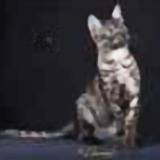

In [ ]:
PIL.Image.open(path_gen.ls()[3])

**Train Critic**

In [ ]:
learn_gen=None
gc.collect()

7

In [ ]:
def get_crit_data(classes, bs, size):
    src = ImageList.from_folder(path, include=classes).split_by_rand_pct(0.1, seed=42)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(max_zoom=2.), size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    data.c = 3
    return data

In [ ]:
data_critic = get_crit_data([name_gen, 'images'], bs=bs, size=size)

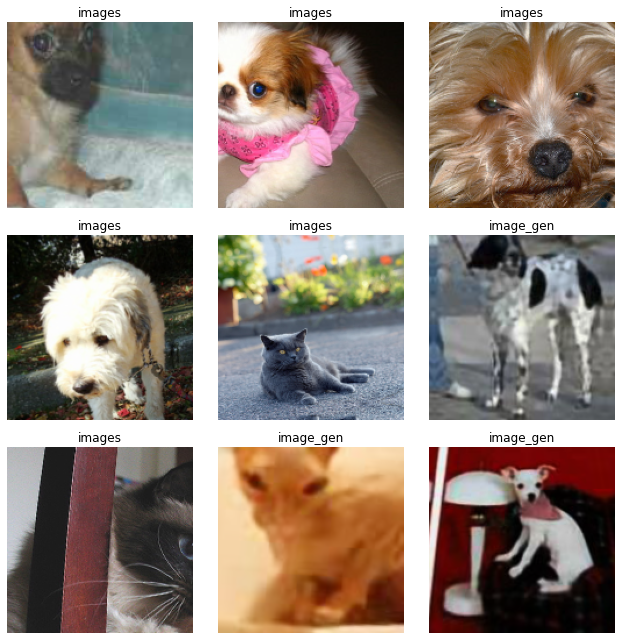

In [ ]:
data_critic.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)

In [ ]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())

In [ ]:
def create_critic_learner(data, metrics):
  return Learner(data, gan_critic(), metrics=metrics, loss_func=loss_critic, wd=wd)

In [ ]:
learn_critic = create_critic_learner(data_critic, accuracy_thresh_expand)

In [ ]:
learn_critic.fit_one_cycle(6, 1e-3)

In [ ]:
learn_critic.save('critic-pre2')

**GAN**

In [ ]:
learn_crit=None
learn_gen=None
gc.collect()

18978

In [ ]:
data_crit = get_crit_data(['crappy','images'], bs=bs, size=size)

In [ ]:
learn_crit = create_critic_learner(data_crit, metrics=None).load('critic-pre2')

In [ ]:
learn_gen = create_gen_learner().load('gen-pre2')

In [ ]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=False, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=wd)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

In [ ]:
lr = 1e-4

In [ ]:
learn.fit(40, lr)

In [ ]:
learn.save('gan-1c')

In [ ]:
learn.data=get_data(16, 192)

In [ ]:
learn.fit(10, lr/2)

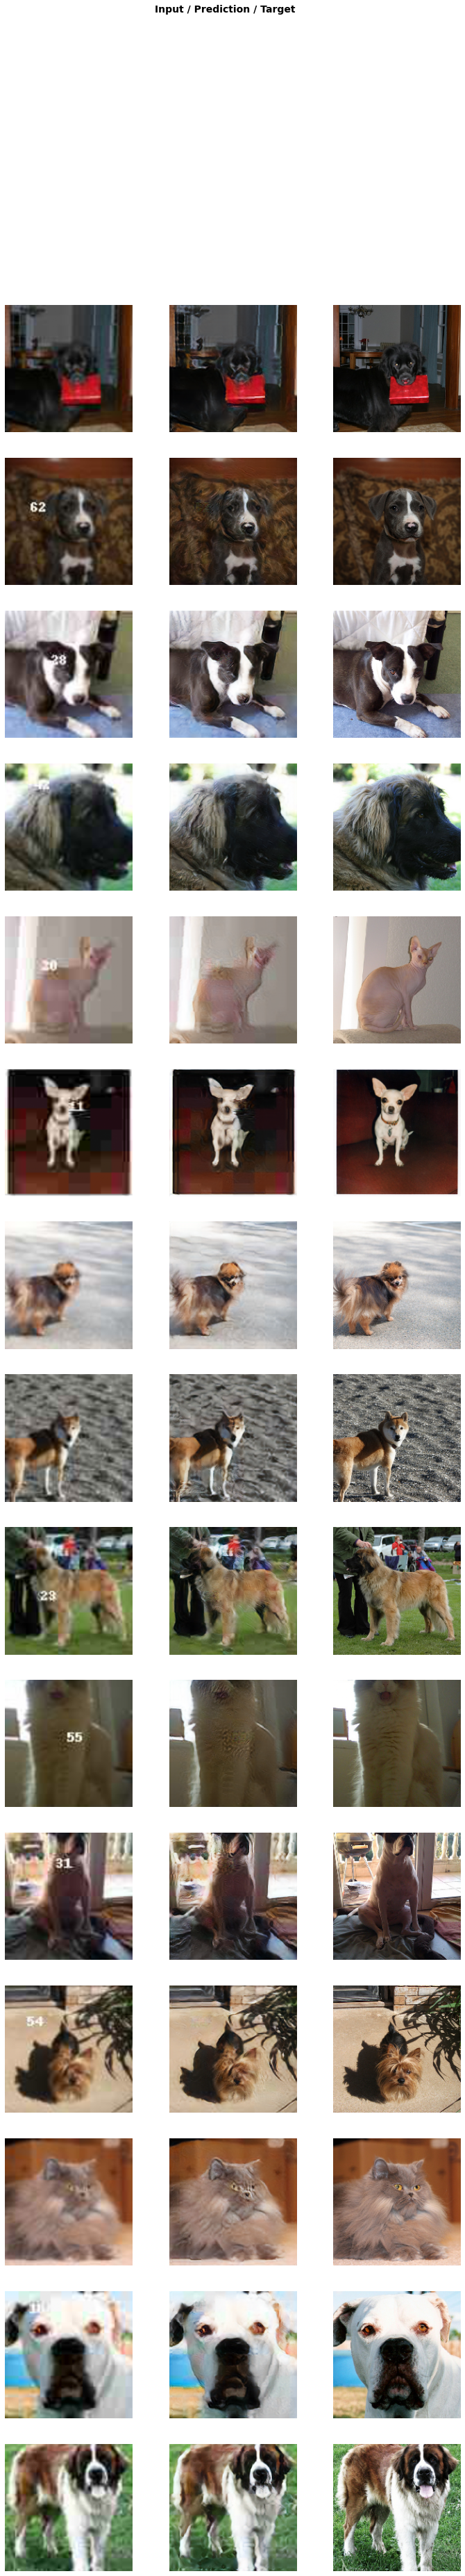

In [ ]:
learn.show_results(rows=15)

In [ ]:
learn.save('gan-1c')